# NLP Seminar 4: Text classification with neural networks (MLPs, RNNs)

In this seminar, we cover the implementation of "all-in-one" text classification neural networks using the `tensorflow` package. The resulting models include both a neural text embedding and a neural classifier in a single pipeline.

The focus is here on two different types of architectures: multi-layer perceptrons (MLPs) and (bidirectional) recurrent neural netrowks (RNNs).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import Sequential

## Data preparation

We again use the Simpsons script dataset. As a toy example, the classification goal is to determine which character is speaking given a textual dialogue line.

Data source: https://www.kaggle.com/datasets/prashant111/the-simpsons-dataset

In [3]:
simpsons = pd.read_csv("../data/simpsons_script_lines.csv",
                       usecols=["raw_character_text", "raw_location_text", "spoken_words", "normalized_text"],
                       dtype={'raw_character_text':'string', 'raw_location_text':'string',
                              'spoken_words':'string', 'normalized_text':'string'})
simpsons.head()

,raw_character_text,raw_location_text,spoken_words,normalized_text
0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...
1,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom
2,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...
3,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living
4,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...


In [4]:
simpsons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158271 entries, 0 to 158270
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   raw_character_text  140749 non-null  string
 1   raw_location_text   157863 non-null  string
 2   spoken_words        132112 non-null  string
 3   normalized_text     132087 non-null  string
dtypes: string(4)
memory usage: 4.8 MB


In [5]:
simpsons = simpsons.dropna().drop_duplicates().reset_index(drop=True)
simpsons.head()

,raw_character_text,raw_location_text,spoken_words,normalized_text
0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...
1,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom
2,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...
3,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living
4,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...


We restrict the data to the 10 most frequent characters.

In [6]:
n_classes = 10
simpsons['raw_character_text'].value_counts(dropna=False)

raw_character_text
Homer Simpson             27253
Marge Simpson             12841
Bart Simpson              12688
Lisa Simpson              10551
C. Montgomery Burns        3043
                          ...  
Sponge                        1
Viking Lenny                  1
Monk #3                       1
Persian Trader                1
Public Radio Announcer        1
Name: count, Length: 6249, dtype: Int64

In [7]:
main_characters = simpsons['raw_character_text'].value_counts(dropna=False)[:n_classes].index.to_list()
main_characters

['Homer Simpson',
 'Marge Simpson',
 'Bart Simpson',
 'Lisa Simpson',
 'C. Montgomery Burns',
 'Moe Szyslak',
 'Seymour Skinner',
 'Ned Flanders',
 'Chief Wiggum',
 'Grampa Simpson']

In [8]:
simpsons_main = simpsons.query("`raw_character_text` in @main_characters")
simpsons_main

,raw_character_text,raw_location_text,spoken_words,normalized_text
1,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom
3,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living
7,Bart Simpson,Springfield Elementary School,Victory party under the slide!,victory party under the slide
8,Lisa Simpson,Apartment Building,Mr. Bergstrom! Mr. Bergstrom!,mr bergstrom mr bergstrom
10,Lisa Simpson,Apartment Building,Do you know where I could find him?,do you know where i could find him
...,...,...,...,...
129781,Lisa Simpson,SIMPSON HOUSE - BASEMENT STAIRCASE,Can we have wine?,can we have wine
129782,Lisa Simpson,SIMPSON HOUSE - BASEMENT STAIRCASE,Can I have wine?,can i have wine
129783,Lisa Simpson,SIMPSON HOUSE - BASEMENT STAIRCASE,Does Bart have to be there?,does bart have to be there
129784,Lisa Simpson,SIMPSON HOUSE - BASEMENT STAIRCASE,Can we do it this week?,can we do it this week


In [9]:
X = simpsons_main["spoken_words"].to_numpy()
y = simpsons_main["raw_character_text"].to_numpy()
y

array(['Lisa Simpson', 'Lisa Simpson', 'Bart Simpson', ...,
       'Lisa Simpson', 'Lisa Simpson', 'Lisa Simpson'], dtype=object)

In [10]:
y_int = np.array([np.where(np.array(main_characters)==char)[0].item() for char in y])
y_int

array([3, 3, 2, ..., 3, 3, 3])

Train-validation data split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y_int, test_size=0.2, random_state=42, shuffle=True)

## TextVectorization and Embedding layers

In a `Sequantial` tensorflow model, the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer is used to transform raw text into bag of words.
For efficiency reasons, the bag-of-words representations are encoded as integers instead of one-hot-vectors.

In [12]:
# A corpus of two arbitrary sentence examples
corp = ["Lunch is ready",
        "It is time for lunch"]

In [13]:
max_vocab = 100
sequence_length = 8
vectorize_layer = layers.TextVectorization(max_tokens=max_vocab, standardize='lower_and_strip_punctuation',
                                           output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(corp)

In [14]:
vectorize_layer(corp)

<tf.Tensor: shape=(2, 8), dtype=int64, numpy=
array([[2, 3, 5, 0, 0, 0, 0, 0],
       [6, 3, 4, 7, 2, 0, 0, 0]], dtype=int64)>

In [15]:
vectorize_layer.get_vocabulary()

['', '[UNK]', 'lunch', 'is', 'time', 'ready', 'it', 'for']

Then, the [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer is usually used to transform the bag-of-words integers to (trainable) vectorial embeddings.

In [16]:
embedder = layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=10,
                            embeddings_initializer='uniform')

In [17]:
embedder(vectorize_layer(corp))

<tf.Tensor: shape=(2, 8, 10), dtype=float32, numpy=
array([[[ 0.0495991 , -0.03023039, -0.03012322, -0.0090551 ,
         -0.02226788, -0.04656243,  0.03547306,  0.0057293 ,
         -0.00671308, -0.03036736],
        [ 0.03898866,  0.01868523,  0.01878494,  0.03762383,
         -0.03224391,  0.00522871,  0.01697693, -0.04838461,
         -0.00971217,  0.00345236],
        [ 0.00324969, -0.01276352, -0.01486113, -0.04547045,
          0.03517162,  0.00809282,  0.01182506,  0.00600661,
          0.04329529,  0.01483018],
        [-0.02043793, -0.04626186,  0.00655951, -0.02283628,
          0.04755343,  0.030037  ,  0.00933196, -0.01490273,
          0.02412501, -0.04835297],
        [-0.02043793, -0.04626186,  0.00655951, -0.02283628,
          0.04755343,  0.030037  ,  0.00933196, -0.01490273,
          0.02412501, -0.04835297],
        [-0.02043793, -0.04626186,  0.00655951, -0.02283628,
          0.04755343,  0.030037  ,  0.00933196, -0.01490273,
          0.02412501, -0.04835297],


## MLP network architectures

In [32]:
# Vocabulary size and number of words in a sequence.
max_vocab = 10000
sequence_length = 100

The `TextVectorization` layer needs to be "adapted" (i.e. needs to construct the vocabulary) before beeing added in a `Sequential` model.

In [33]:
# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum sequence length as all samples are not of the same length.

vectorize_layer = layers.TextVectorization(max_tokens=max_vocab, standardize='lower_and_strip_punctuation',#or custom
                                           output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(X_train)

In [35]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'i', 'you', 'a', 'to', 'and', 'of', 'it',
       'that', 'my', 'in', 'is', 'this', 'me', 'im', 'for', 'your', 'oh'],
      dtype='<U18')

We construct a toy MLP example on top of the embedding layers, using the `Sequential` class.

In [36]:
embedding_dim=50

MLP_model = Sequential([
    layers.Input(shape=(1,), dtype="string"),
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                     embeddings_initializer='uniform'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
], name="MLP_model")

MLP_model.summary()

Model: "MLP_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 100, 50)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,914 (1.92 MB)

 Trainable params: 503,914 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

We assign the `Adam` optimizer and the `SparseCategoricalCrossentropy` loss to the model for training.
We then train the model on the training data and log the validation loss.

In [37]:
MLP_model.compile(optimizer=optimizers.Adam(),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [38]:
epochs = 10
history_MLP = MLP_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                            batch_size=128, epochs=epochs)

MLP_model.save_weights("./checkpoints/MLP_10/MLP_10.weights.h5") # Save the network's weights
#MLP_model.save("./checkpoints/MLP_10_model") #for saving the whole model object

Epoch 1/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3434 - loss: 1.9029 - val_accuracy: 0.3567 - val_loss: 1.8477
Epoch 2/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3499 - loss: 1.8631 - val_accuracy: 0.3567 - val_loss: 1.8383
Epoch 3/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3546 - loss: 1.8422 - val_accuracy: 0.3566 - val_loss: 1.8106
Epoch 4/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3731 - loss: 1.7857 - val_accuracy: 0.3892 - val_loss: 1.7460
Epoch 5/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4081 - loss: 1.7101 - val_accuracy: 0.4035 - val_loss: 1.6836
Epoch 6/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4300 - loss: 1.6407 - val_accuracy: 0.3951 - val_loss: 1.6641
Epoch 7/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4419 - loss: 1.5967 - val_accuracy: 0.4276 - val_loss: 1.6280
Epoch 8/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4544 - loss: 1.5611 - val_accuracy: 0.

In [39]:
MLP_model.load_weights("./checkpoints/MLP_10/MLP_10.weights.h5")

We evaluate the model on the validation data, and inspect the training `history`.

In [40]:
loss, accuracy = MLP_model.evaluate(X_valid, y_valid)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4417 - loss: 1.5935
Loss:  1.6087344884872437
Accuracy:  0.4388647675514221


In [42]:
history_MLP_dict = history_MLP.history
history_MLP_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [43]:
def plot_training(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b--', label='Training')
    plt.plot(epochs, val_loss, 'r-', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b--', label='Training')
    plt.plot(epochs, val_acc, 'r-', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    plt.show()

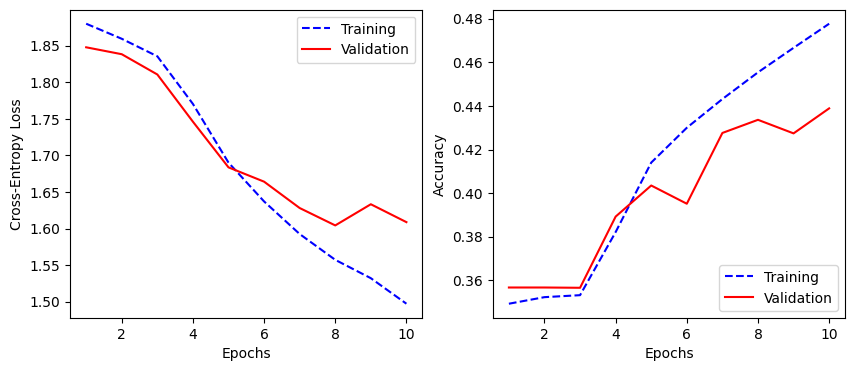

In [44]:
plot_training(history_MLP_dict)

We predict the expected character for a few new line examples.

In [45]:
examples = np.array(["Homer, come here!",
                     "Science is amazing.",
                     "Duh"], 
                    dtype="object")

MLP_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[0.11668233, 0.5205199 , 0.04899754, 0.01390479, 0.01067009,
        0.09533361, 0.02510195, 0.12756525, 0.02045671, 0.02076782],
       [0.20407827, 0.1438266 , 0.14693789, 0.3326701 , 0.04106684,
        0.00853114, 0.07321886, 0.01823796, 0.01439785, 0.0170345 ],
       [0.45998532, 0.2000142 , 0.11140469, 0.09302893, 0.03441824,
        0.01786987, 0.02369256, 0.02436291, 0.01336884, 0.02185444]],
      dtype=float32)

In [47]:
def predict_class(tf_model, data, class_names=main_characters):
    """Returns the string model predictions (class name of the largest network output activation)."""
    return np.array(class_names)[tf_model.predict(data).argmax(axis=1)]

In [48]:
predict_class(MLP_model, examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array(['Marge Simpson', 'Lisa Simpson', 'Homer Simpson'], dtype='<U19')

A few tutorials for more details:
- https://www.tensorflow.org/text/guide/word_embeddings
- https://www.tensorflow.org/tutorials/keras/text_classification

##  Recurrent network architectures

We now construct a few recurrent architectures on top of the embedding layers. Those allow to capture sequential dependencies in the input text sequences through latent variables, and also dealing with varying text sequence lengths.

The three main type of recurrent layers implemented in `tensorflow` are: `SimpleRNN`, `LSTM` and `GRU`.
We here use the LSTM layers, but one can in principle substitute it for any of the others.

As the meaning of a word can sometimes depend not only on the context preceding it, but also succeeding it, "Bidirectional" recurrent architectures are often used in some NLP tasks. The `Bidirectional` layer wrapper allows to implement this easily in a `Sequential` model

A few tutorials to go further:
- https://www.tensorflow.org/text/tutorials/text_classification_rnn
- https://www.tensorflow.org/guide/keras/rnn

In [49]:
max_vocab = 10000
vectorize_layer = layers.TextVectorization(max_tokens=max_vocab, standardize='lower_and_strip_punctuation',
                                           output_mode='int', output_sequence_length=None)
vectorize_layer.adapt(X_train)

Here are a few example of LSTM-based architectures:

In [51]:
embedding_dim=50

# Using masking with 'mask_zero=True' to handle the variable sequence lengths in subsequent layers.

LSTM_model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype="string"),
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                     embeddings_initializer='uniform', mask_zero=True),
    layers.LSTM(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
], name="LSTM_model")

BLSTM_model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype="string"),
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                     embeddings_initializer='uniform', mask_zero=True),
    layers.Bidirectional(layers.LSTM(64), merge_mode='concat'),
    layers.Dense(n_classes, activation='softmax')
], name="BLSTM_model")

BLSTM2_model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype="string"),
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                     embeddings_initializer='uniform', mask_zero=True),
    layers.Bidirectional(layers.LSTM(64,  return_sequences=True), merge_mode='concat'),
    layers.Bidirectional(layers.LSTM(32,  return_sequences=False), merge_mode='concat'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
], name="BLSTM2_model")


(Using masking with `'mask_zero=True'` in the embedding to handle the variable sequence lengths in subsequent layers: https://www.tensorflow.org/guide/keras/masking_and_padding)

In [52]:
BLSTM_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

In [ ]:
epochs = 10#100
history_lstm = BLSTM_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                               batch_size=128, epochs=epochs)

BLSTM_model.save_weights("./checkpoints/BLSTM_10/BLSTM_10.weights.h5")
#BLSTM_model.save("./checkpoints/BLSTM_10_model")

history_lstm_dict = history_lstm.history
json.dump(history_lstm_dict, open("./checkpoints/history/BLSTM_10.txt", 'w'))

In [53]:
BLSTM_model.load_weights("./checkpoints/BLSTM_10/BLSTM_10.weights.h5")
history_lstm_dict = json.load(open("./checkpoints/history/BLSTM_10.txt", 'r'))

c:\Users\pascheo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4296 - loss: 1.6393
Test Loss: 1.6505235433578491
Test Accuracy: 0.4305708408355713


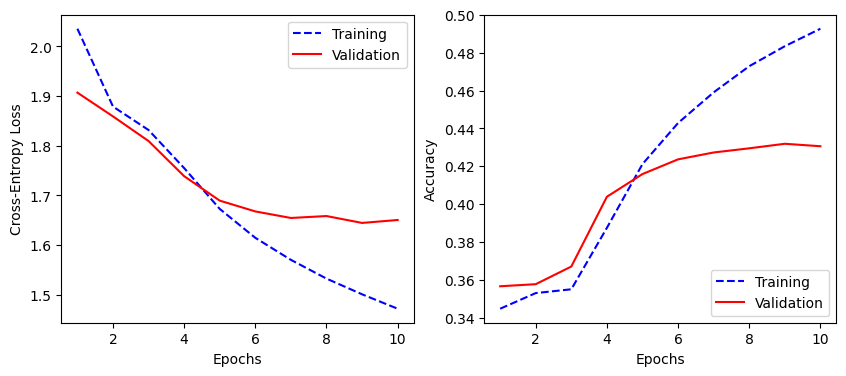

In [54]:
test_loss, test_acc = BLSTM_model.evaluate(X_valid, y_valid)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plot_training(history_lstm_dict)

In [56]:
# BLSTM_model.predict(examples)
predict_class(BLSTM_model, examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array(['Marge Simpson', 'Lisa Simpson', 'Homer Simpson'], dtype='<U19')

## Using pretrained word vectors

Instead of randomly initializing the `Embedding` layer, one can give pretrained word vectors to it.
We here use pretrained GloVe vectors.

In [57]:
from gensim.models import KeyedVectors
import gensim.downloader as gensim_api

In [58]:
embedding_dim = 100
glv_embd = gensim_api.load("glove-wiki-gigaword-100")

In [59]:
glv_embd.get_vector('eat', norm=True)

array([-0.13200806,  0.12168139,  0.05111479, -0.09194282, -0.16854355,
        0.11843582, -0.01637641,  0.057581  ,  0.06060887, -0.1583864 ,
        0.0122843 ,  0.09658599,  0.07887745,  0.09955403,  0.03300575,
       -0.02709626, -0.03575277,  0.03952846, -0.10017057,  0.08118574,
        0.05584438,  0.01468815, -0.02233842, -0.1326595 , -0.04105403,
        0.12740144, -0.14893885, -0.12442177,  0.04468182,  0.0662292 ,
       -0.0873146 ,  0.1413991 ,  0.04768809, -0.06280249,  0.08584885,
        0.21455982,  0.02440907,  0.06502936,  0.00062497, -0.12080893,
        0.02526325, -0.04787754, -0.15381967, -0.1373575 , -0.00716069,
        0.02242317, -0.1170914 , -0.01161691, -0.08390118, -0.16044708,
        0.00944007, -0.06349216, -0.02596621,  0.08273789, -0.10063589,
       -0.17087013, -0.02296992,  0.01123867,  0.17743438, -0.05270185,
        0.01918259,  0.20799556, -0.01252809, -0.16598764,  0.11645491,
        0.05835043,  0.05360921, -0.07023423,  0.06619596, -0.11

In [60]:
max_vocab = 10000
vectorize_layer = layers.TextVectorization(max_tokens=max_vocab, standardize='lower_and_strip_punctuation',
                                           output_mode='int', output_sequence_length=None)
vectorize_layer.adapt(X_train)

In [64]:
vocab = vectorize_layer.get_vocabulary(include_special_tokens=True)
embedding_matrix = np.random.uniform(-0.05, 0.05, (len(vocab), embedding_dim))

oov_words = list()
for i, w in enumerate(vocab):
    try:
        embedding_matrix[i,] = glv_embd.get_vector(w, norm=True)
    except:
        embedding_matrix[i,] = embedding_matrix[1,]
        oov_words += [w]

#print(oov_words)
print(len(oov_words))

437


In [66]:
embedder = layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            mask_zero=True, trainable=False, name='embedding')

In [67]:
X_train[[7]]

array(['Finally I realized if I was ever going to get out of there, I would have to do it myself.'],
      dtype=object)

In [68]:
glv_embd.get_vector("finally", norm=True)

array([ 0.12676363, -0.05699045,  0.07344589,  0.03163813,  0.0091377 ,
        0.00973021,  0.02216944,  0.0485875 ,  0.10702284, -0.13639013,
        0.17047742,  0.06009134,  0.05314559,  0.07110946,  0.04354573,
       -0.11332506,  0.06841231,  0.09726313, -0.09638799, -0.06351196,
        0.0042937 , -0.02317575,  0.00517991, -0.03167707,  0.07351557,
        0.05046484, -0.10052183, -0.10115923,  0.12830895, -0.09516443,
       -0.04108838,  0.1520442 , -0.04745412,  0.02095409, -0.00392295,
       -0.11140673, -0.06393621, -0.05125185,  0.01868775, -0.03329208,
       -0.14061621, -0.09789848,  0.07564705, -0.11232696,  0.027865  ,
       -0.01940713,  0.04005953, -0.03991811,  0.22366194, -0.14765829,
       -0.00381637, -0.06168995,  0.04260706,  0.26252046,  0.03506285,
       -0.46039972, -0.1147884 ,  0.01342587,  0.16513027,  0.15626618,
        0.02464114,  0.1059612 , -0.11800817,  0.01163255,  0.157211  ,
       -0.00469725, -0.03396227,  0.05660515, -0.08130982, -0.02

In [71]:
embedder(vectorize_layer(X_train[[7]]))[0,0,].numpy()

array([ 0.12676363, -0.05699045,  0.07344589,  0.03163813,  0.0091377 ,
        0.00973021,  0.02216944,  0.0485875 ,  0.10702284, -0.13639013,
        0.17047742,  0.06009134,  0.05314559,  0.07110946,  0.04354573,
       -0.11332506,  0.06841231,  0.09726313, -0.09638799, -0.06351196,
        0.0042937 , -0.02317575,  0.00517991, -0.03167707,  0.07351557,
        0.05046484, -0.10052183, -0.10115923,  0.12830895, -0.09516443,
       -0.04108838,  0.1520442 , -0.04745412,  0.02095409, -0.00392295,
       -0.11140673, -0.06393621, -0.05125185,  0.01868775, -0.03329208,
       -0.14061621, -0.09789848,  0.07564705, -0.11232696,  0.027865  ,
       -0.01940713,  0.04005953, -0.03991811,  0.22366194, -0.14765829,
       -0.00381637, -0.06168995,  0.04260706,  0.26252046,  0.03506285,
       -0.46039972, -0.1147884 ,  0.01342587,  0.16513027,  0.15626618,
        0.02464114,  0.1059612 , -0.11800817,  0.01163255,  0.157211  ,
       -0.00469725, -0.03396227,  0.05660515, -0.08130982, -0.02

In [72]:
sum(glv_embd.get_vector("finally", norm=True) != embedder(vectorize_layer(X_train[[7]])).numpy()[0,0,])

0

In [74]:
#Pretrained embeddings:
BLSTM_Glv_model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype="string"),
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                     embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                     mask_zero=True, trainable=False, name='embedding'),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(n_classes, activation='softmax')
], name="BLSTM_Glv_model")

In [ ]:
BLSTM_Glv_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                        metrics=['accuracy'])

epochs_f = 15
epochs_t = epochs_f + 5

# Probably not ideal, but as an idea of what one can do:

# Train the rest of the network, keeping the embedding layer frozen to the pre-trained vectors.

history_glv_f = BLSTM_Glv_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                                    batch_size=128, epochs=epochs_f)
BLSTM_Glv_model.save_weights("./checkpoints/Glv_15/Glv_15.weights.h5")

# Optionally, unfreeze the embedding layer, to fine-tune the whole network, including the embeddings.

BLSTM_Glv_model.layers[1].trainable = True

history_glv_l = BLSTM_Glv_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                                    batch_size=128, epochs=epochs_t, initial_epoch=epochs_f)
BLSTM_Glv_model.save_weights("./checkpoints/Glv_20/Glv_20.weights.h5")

In [ ]:
BLSTM_Glv_model.load_weights("./checkpoints/Glv_20/Glv_20.weights.h5")

In [ ]:
test_loss, test_acc = BLSTM_Glv_model.evaluate(X_valid, y_valid)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Exercise: Fine tuning

Try to achieve the best validation accuracy by fine-tuning the hyperparameters of any method above.

The following two `callbacks` examples could be useful during training:
```python
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = "checkpoint/metwork_epoch={epoch:02d}-val_accuracy={val_accuracy:.2f}.h5")
    callbacks=[early_stopping_cb, checkpoint_cb]
```
To go further, `keras_tuner` can also be useful: https://www.tensorflow.org/tutorials/keras/keras_tuner.

#### draft...

In [ ]:
#json.dump(history_MLP.history, open("./checkpoints/history/MLP_10.txt", 'w'))
history_MLP_dict = json.load(open("./checkpoints/history/MLP_10.txt", 'r'))

In [ ]:
#json.dump(history_lstm.history, open("./checkpoints/history/BLSTM_10.txt", 'w'))
history_lstm_dict = json.load(open("./checkpoints/history/BLSTM_10.txt", 'r'))